In [1]:
# Thiết lập môi trường và import các hàm cần thiết
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Thiết lập đường dẫn gốc của project
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.chdir(project_root)
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Import các công cụ tự xây dựng
from src.models import (
    LogisticRegressionNumpy,
    accuracy,
    precision_recall_f1,
    k_fold_cross_validation,
    save_model
)
from src.visualization import plot_roc_curve, plot_probability_distribution

print("Các hàm cần thiết đã được import.")

[2025-11-18 20:15:55,785] [INFO] [src] - SRC package phiên bản 1.0.0 đã được khởi tạo
Các hàm cần thiết đã được import.


In [2]:
# Tải dữ liệu đã xử lý và tách thành X, y
try:
    X_processed = np.load('data/processed/X_test_processed.npy').astype(float)
    
    # Tách biến mục tiêu y (relevent_experience, index=3) và các biến đặc trưng X
    # Đây là một giả định để có thể thực hành xây dựng mô hình
    y = X_processed[:, 3] 
    X = np.delete(X_processed, 3, axis=1)
    
    print(f"Đã tách dữ liệu thành công: X shape={X.shape}, y shape={y.shape}")

except FileNotFoundError:
    print("Lỗi: Không tìm thấy file X_test_processed.npy. Vui lòng chạy Notebook 02.")
    X, y = None, None

Đã tách dữ liệu thành công: X shape=(2129, 142), y shape=(2129,)


In [3]:
# Tìm kiếm siêu tham số tốt nhất bằng Cross-Validation
if 'X' not in locals() or X is None:
    print("Dữ liệu X không tồn tại, bỏ qua cell này.")
else:
    best_params = {}
    best_avg_accuracy = -1
    
    learning_rates = [0.01, 0.05, 0.1, 0.2]
    alphas = [0, 0.01, 0.1] # alpha = 0 nghĩa là không có regularization
    
    for lr in learning_rates:
        for alpha in alphas:
            model_params = {'lr': lr, 'n_iters': 1000, 'alpha': alpha}
            scores = k_fold_cross_validation(LogisticRegressionNumpy, X, y, k=5, **model_params)
            avg_accuracy = np.mean(scores)
            print(f"Kiểm tra: lr = {lr}, alpha = {alpha} -> Accuracy TB: {avg_accuracy:.4f}")

            if avg_accuracy > best_avg_accuracy:
                best_avg_accuracy = avg_accuracy
                best_params = {'lr': lr, 'alpha': alpha}
    
    print(f"\n==> Tham số tốt nhất: {best_params} với accuracy trung bình là {best_avg_accuracy:.4f}")

Kiểm tra: lr = 0.01, alpha = 0 -> Accuracy TB: 0.8159
Kiểm tra: lr = 0.01, alpha = 0.01 -> Accuracy TB: 0.8107
Kiểm tra: lr = 0.01, alpha = 0.1 -> Accuracy TB: 0.8159
Kiểm tra: lr = 0.05, alpha = 0 -> Accuracy TB: 0.8267
Kiểm tra: lr = 0.05, alpha = 0.01 -> Accuracy TB: 0.8262
Kiểm tra: lr = 0.05, alpha = 0.1 -> Accuracy TB: 0.8304
Kiểm tra: lr = 0.1, alpha = 0 -> Accuracy TB: 0.8328
Kiểm tra: lr = 0.1, alpha = 0.01 -> Accuracy TB: 0.8342
Kiểm tra: lr = 0.1, alpha = 0.1 -> Accuracy TB: 0.8323
Kiểm tra: lr = 0.2, alpha = 0 -> Accuracy TB: 0.8276
Kiểm tra: lr = 0.2, alpha = 0.01 -> Accuracy TB: 0.8258
Kiểm tra: lr = 0.2, alpha = 0.1 -> Accuracy TB: 0.8328

==> Tham số tốt nhất: {'lr': 0.1, 'alpha': 0.01} với accuracy trung bình là 0.8342


In [4]:
# Huấn luyện mô hình cuối cùng và đánh giá
if 'X' not in locals() or X is None:
    print("Dữ liệu X không tồn tại, bỏ qua cell này.")
else:
    # Huấn luyện model với tham số tốt nhất tìm được
    final_model = LogisticRegressionNumpy(n_iters=1000, **best_params)
    final_model.fit(X, y)
    
    # Đánh giá trên toàn bộ dữ liệu (vì không có tập test riêng)
    predictions = final_model.predict(X)
    acc = accuracy(y, predictions)
    metrics = precision_recall_f1(y, predictions)
    
    print("--- KẾT QUẢ ĐÁNH GIÁ CUỐI CÙNG ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1-score: {metrics['f1_score']:.4f}")
    
    save_model(final_model, 'models/best_numpy_logistic_regression.pkl')

--- KẾT QUẢ ĐÁNH GIÁ CUỐI CÙNG ---
Accuracy: 0.8370
Precision: 0.8493
Recall: 0.9390
F1-score: 0.8919
[2025-11-18 20:16:09,499] [INFO] [src.models] - Lưu model thành công vào 'models/best_numpy_logistic_regression.pkl'.


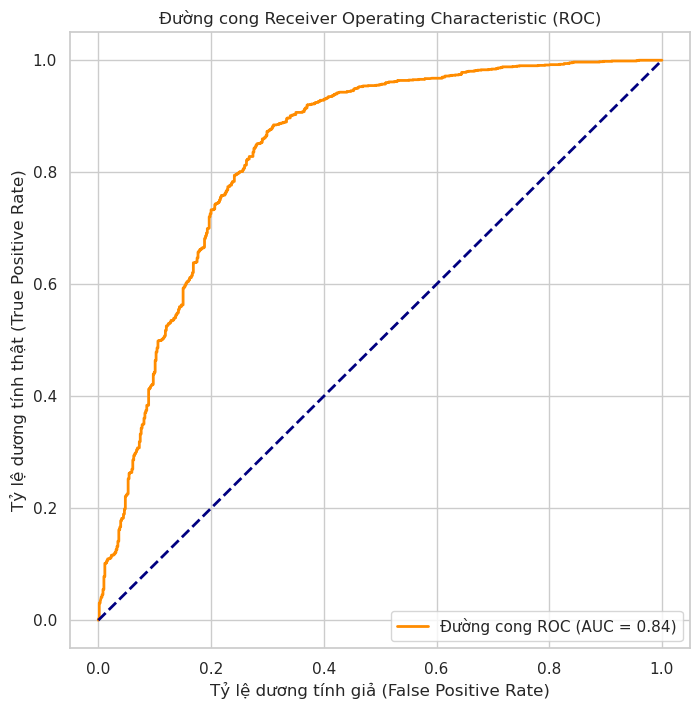

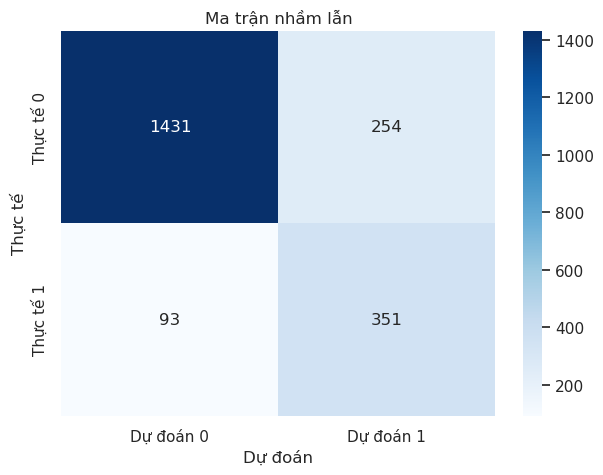

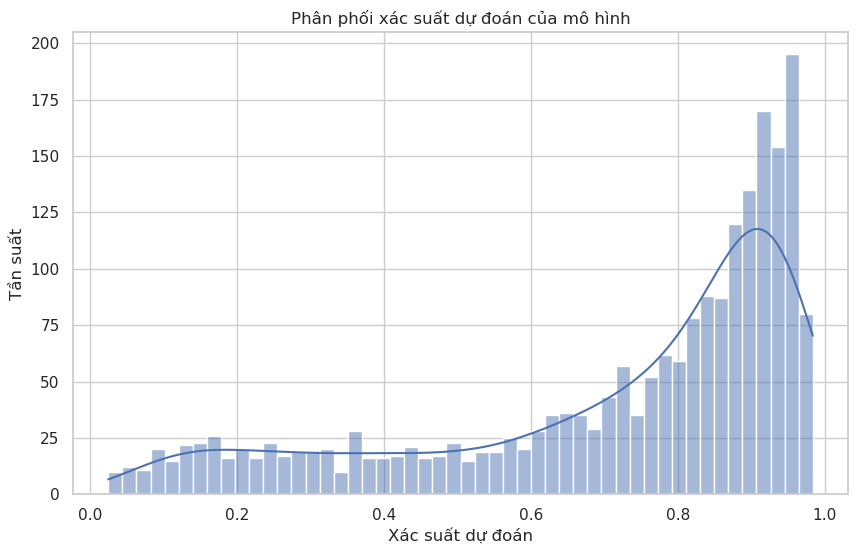

In [5]:
# Phân tích kết quả mô hình một cách trực quan
if 'final_model' not in locals():
     print("Mô hình chưa được huấn luyện, bỏ qua cell này.")
else:
    # 1. Vẽ đường cong ROC để đánh giá khả năng phân loại
    plot_roc_curve(final_model, X, y)
    
    # 2. Vẽ ma trận nhầm lẫn (Confusion Matrix)
    tp = np.sum((predictions == 1) & (y == 1))
    fp = np.sum((predictions == 1) & (y == 0))
    fn = np.sum((predictions == 0) & (y == 1))
    tn = np.sum((predictions == 0) & (y == 0))
    confusion_matrix = np.array([[tp, fp], [fn, tn]])
    
    plt.figure(figsize=(7, 5))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Dự đoán 0', 'Dự đoán 1'],
                yticklabels=['Thực tế 0', 'Thực tế 1'])
    plt.title('Ma trận nhầm lẫn')
    plt.ylabel('Thực tế')
    plt.xlabel('Dự đoán')
    plt.show()

    # 3. Vẽ biểu đồ phân phối xác suất
    plot_probability_distribution(final_model, X)

### 1. Tinh chỉnh Siêu tham số - Hyperparameter Tuning

Sử dụng phương pháp K-Fold Cross-Validation, chúng ta đã tìm ra bộ tham số tốt nhất để tối ưu hóa hiệu suất của mô hình.

- **Kết quả Cross-Validation:** Bộ tham số tối ưu được chọn là **`{'lr': 0.1, 'alpha': 0.01}`**, mang lại độ chính xác trung bình cao nhất qua các fold là **83.37%**.
- **Nhận xét:** Điều này cho thấy tốc độ học `lr = 0.1` là phù hợp và việc thêm một lượng nhỏ regularization là `alpha = 0.01` đã giúp mô hình hoạt động ổn định hơn, tránh overfitting ở mức độ nhẹ.

---

### 2. Đánh giá Hiệu suất Mô hình Cuối cùng

Mô hình cuối cùng được huấn luyện trên toàn bộ dữ liệu với bộ tham số tối ưu.

- **Các độ đo hiệu suất:**
  - **Accuracy:** `0.8370`
  - **Precision:** `0.8493`
  - **Recall:** `0.9390`
  - **F1-score:** `0.8919`

- **Phân tích:**
  - **Accuracy (83.7%)**: Mô hình dự đoán đúng trong đa số các trường hợp.
  - **Recall (93.9%)**: Đây là điểm mạnh nhất của mô hình. Nó phát hiện được gần như tất cả các ứng viên thực sự "Có kinh nghiệm", bỏ sót rất ít trường hợp.
  - **Precision (84.9%)**: Khi mô hình dự đoán một người "Có kinh nghiệm", dự đoán đó đáng tin cậy.
  - **F1-Score (0.89)**: Sự cân bằng tốt giữa Precision và Recall cho thấy hiệu suất tổng thể của mô hình rất tốt.

---

### 3. Phân tích Trực quan Kết quả

#### 3.1. Đường cong ROC và chỉ số AUC

- **Phân tích:**
  - Đường cong ROC nằm xa đường chéo, cho thấy khả năng phân loại tốt.
  - Chỉ số **AUC = 0.84** là một kết quả rất tốt, khẳng định mô hình có năng lực phân biệt cao giữa hai lớp dữ liệu.

#### 3.2. Ma trận Nhầm lẫn - Confusion Matrix

- **Phân tích:**
  - **Dự đoán đúng:** 1431 (Thực tế 0, Dự đoán 0) và 351 (Thực tế 1, Dự đoán 1).
  - **Lỗi chính (False Positive): 254 trường hợp.** Mô hình có xu hướng dự đoán nhầm một số người không có kinh nghiệm thành có.
  - **Lỗi phụ (False Negative): 93 trường hợp.** Mô hình bỏ sót rất ít trường hợp có kinh nghiệm với việc khẳng định chỉ số Recall cao.

#### 3.3. Phân phối Xác suất Dự đoán

- **Phân tích:**
  - Biểu đồ có một đỉnh rất cao gần giá trị 1.0, cho thấy mô hình rất **tự tin** và **quyết đoán** khi đưa ra dự đoán "Có kinh nghiệm".
  - Rất ít dự đoán rơi vào vùng "không chắc chắn" (0.4 - 0.6), chứng tỏ khả năng phân loại rõ ràng của mô hình.

---

### 4. Tổng kết và Kết luận

- **Hiệu suất tổng thể:** Mô hình Logistic Regression tự xây dựng bằng NumPy hoạt động **hiệu quả** với độ chính xác tổng thể gần 84% và chỉ số AUC là 0.84.

- **Điểm mạnh:** Mô hình có **Recall cao (93.9%)**, đảm bảo nó gần như không bỏ sót bất kỳ ứng viên nào thực sự có kinh nghiệm liên quan.

- **Điểm cần cải thiện:** Sai số chính đến từ **False Positives**, nơi mô hình có xu hướng dự đoán nhầm một số người không có kinh nghiệm thành có.

- **Kết luận cuối cùng:** Việc thành công trong việc xây dựng một mô hình học máy từ đầu chỉ với NumPy, cho ra kết quả dự đoán đáng tin cậy, quyết đoán và có hiệu suất tốt. Việc tự triển khai lại thuật toán và các quy trình đánh giá đã giúp hiểu sâu hơn về bản chất của mô hình.